# Exploring Correlations between Wildfire Smoke Exposure and Respiratory Mortality Rates

## Introduction

Wildfire smoke poses significant health risks, particularly concerning respiratory diseases. In this Jupyter notebook, we aim to investigate potential correlations between estimated wildfire smoke exposure and respiratory mortality rates using data from the Institute for Health Metrics and Evaluation (IHME). The proliferation of wildfires in recent years has raised concerns about the impact of wildfire smoke on public health. Previous studies have suggested a link between exposure to wildfire smoke and increased respiratory health problems. This analysis builds upon prior notebooks in the repository that incorporates a smoke estimate model developed using wildfire data .

The primary objective of this analysis is to explore potential relationships between estimated smoke exposure derived from a previously developed model and mortality rates associated with various respiratory diseases. By leveraging the smoke estimate model, which takes into account factors such as fire proximity and affected area, we aim to identify potential correlations with mortality rates due to respiratory illnesses.


In [1]:
#importing the required libraries
import json
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

## Smoke Estimate Model

In [2]:
# importing the wildfire dataset for Grand Junction
with open('../data/Grand_Junction_Wildfire_Features_geometry_dropped.json') as f:
    my_features = json.load(f)

In [3]:
# Finding the average smoke created each year using our smoke estimate model
total_smoke = {}
count_per_year = {}

for fire in my_features:
    year = fire['attributes']['Fire_Year']
    area = fire['attributes']['GIS_Hectares']
    distance = fire['attributes']['distance_from_city']
    smoke_created = 1.2* (1- distance/1250)*(150-area/150) 
    
    if year in total_smoke:
        total_smoke[year] += smoke_created
        count_per_year[year] += 1
    else:
        total_smoke[year] = smoke_created
        count_per_year[year] = 1

# Calculate the average smoke created for each year
average_smoke = {year: total_smoke[year] / count_per_year[year] for year in total_smoke}

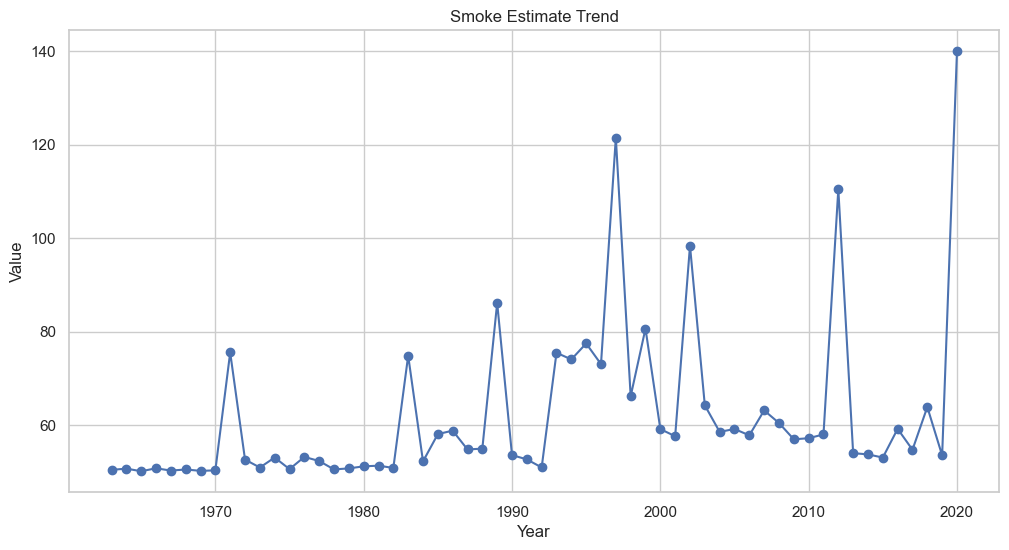

In [75]:
#Plotting the trend
years = list(average_smoke.keys())
values = list(average_smoke.values())

plt.figure(figsize=(12, 6))
plt.plot(years, values, marker='o', linestyle='-')
plt.title('Smoke Estimate Trend')
plt.xlabel('Year')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [7]:
# Converting this to a pandas Dataframe
average_smoke_area_distance_estimate = pd.DataFrame(list(average_smoke.items()), columns=['Year', 'Smoke Estimate'])

Let us plot what the distance of an average fire is from grand junction every year.

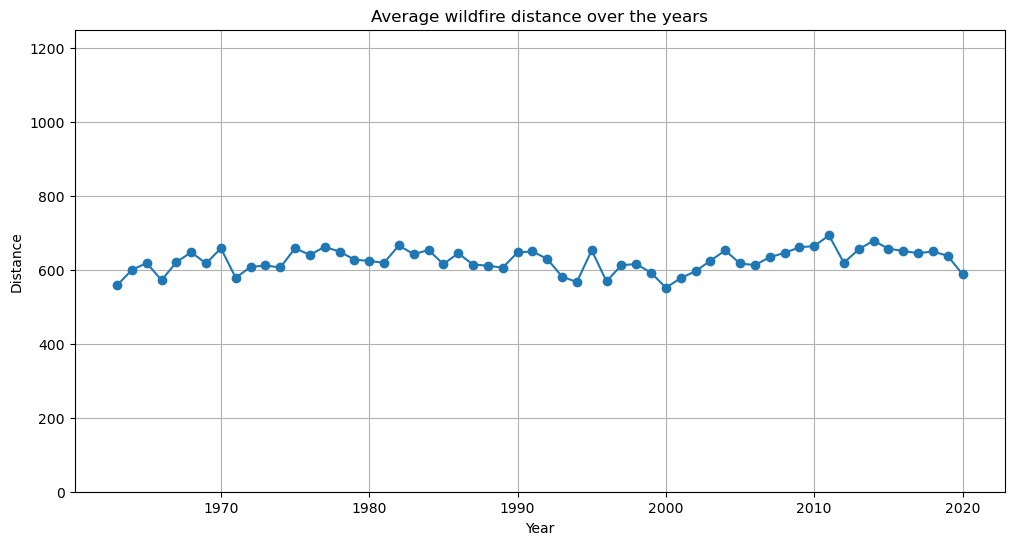

In [11]:
#Total Distance per year - to observe a pattern, if present

total_distance = {}
count_per_year = {}

for fire in my_features:
    year = fire['attributes']['Fire_Year']
    area = fire['attributes']['GIS_Hectares']
    distance = fire['attributes']['distance_from_city']
    
    if year in total_distance:
        total_distance[year] += distance
        count_per_year[year] += 1
    else:
        total_distance[year] = distance
        count_per_year[year] = 1

# Calculate the average smoke created for each year
average_distance = {year: total_distance[year] / count_per_year[year] for year in total_distance}

# Plot the result        
years = list(average_distance.keys())
values = list(average_distance.values())

plt.figure(figsize=(12, 6))
plt.plot(years, values, marker='o', linestyle='-')
plt.title('Average wildfire distance over the years')
plt.xlabel('Year')
plt.ylabel('Distance')
plt.ylim(0, 1250)
plt.grid(True)
plt.show()

Average wildfire distance over the years seem to be around 600 miles away from Grand junction throughout the years

## Mortality data

Now, lets import the mortality data, and plot the values

In [80]:
health_data = pd.read_csv('../data/IHME_USA_COUNTY_RESP_DISEASE_MORTALITY_1980_2014_COLORADO_Y2017M09D26.CSV')

The data contains details of multiple counties in the United States, hence, we would need to filter relevant information for our county.

In [81]:
health_data = health_data[health_data['location_name']=='Mesa County']
# Drop the unnecessary columns
health_data.drop(['measure_id', 'location_id', 'FIPS','measure_name','age_id','age_name'], axis=1, inplace = True)

Let us see the different causes of death that are present in the dataset for our county.

In [17]:
health_data['cause_name'].unique()

array(['Chronic respiratory diseases',
       'Chronic obstructive pulmonary disease', 'Pneumoconiosis',
       'Silicosis', 'Asbestosis', 'Coal workers pneumoconiosis',
       'Other pneumoconiosis', 'Asthma',
       'Interstitial lung disease and pulmonary sarcoidosis',
       'Other chronic respiratory diseases'], dtype=object)

In [18]:
# Let's look at how this variable is used in here
health_data['sex'].unique()

array(['Male', 'Female', 'Both'], dtype=object)

In the interest of time, let us deal with 3 causes of deaths, divided by gender and see if there are any gender based descrepancies in the data for each disease. The 3 diseases that we choose are:
- Other chronic respiratory diseases
- Interstitial lung disease and pulmonary sarcoidosis
- Chronic respiratory diseases


Causes like 'Silicosis' and 'Asbestosis' are occupation based, and hence can't be used in here for wildfire related mortality analysis. Let us plot the trend lines, and the correlation for each to observer if they are increasing aver the years, just like the Smoke estimate

In [42]:
#Convert the data for further joining and processing
average_smoke_area_distance_estimate_data['Year'] = average_smoke_area_distance_estimate_data['Year'].dt.year

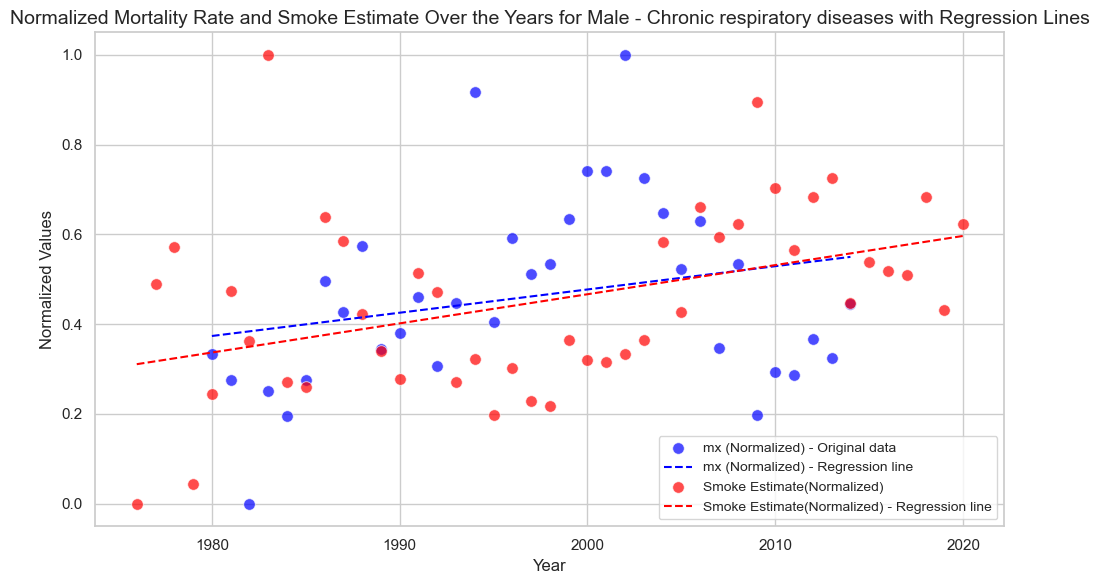

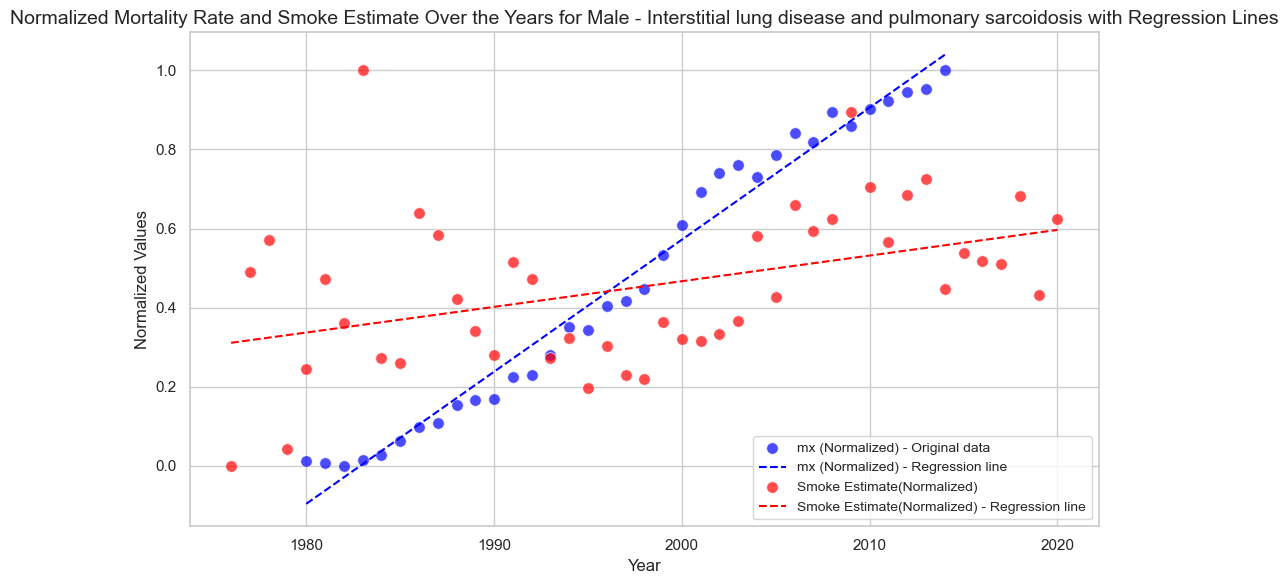

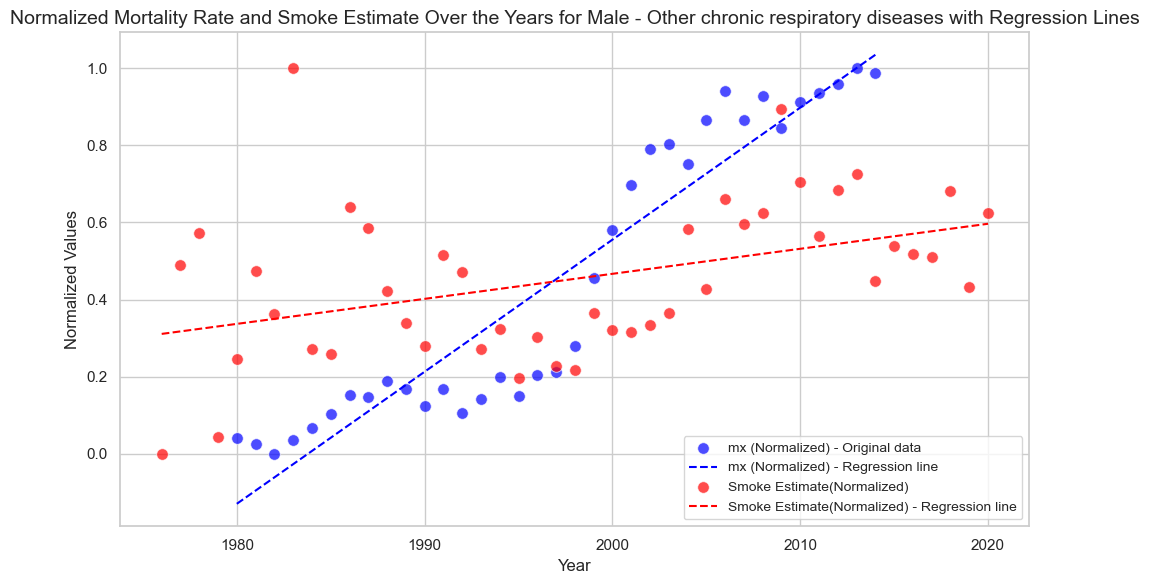

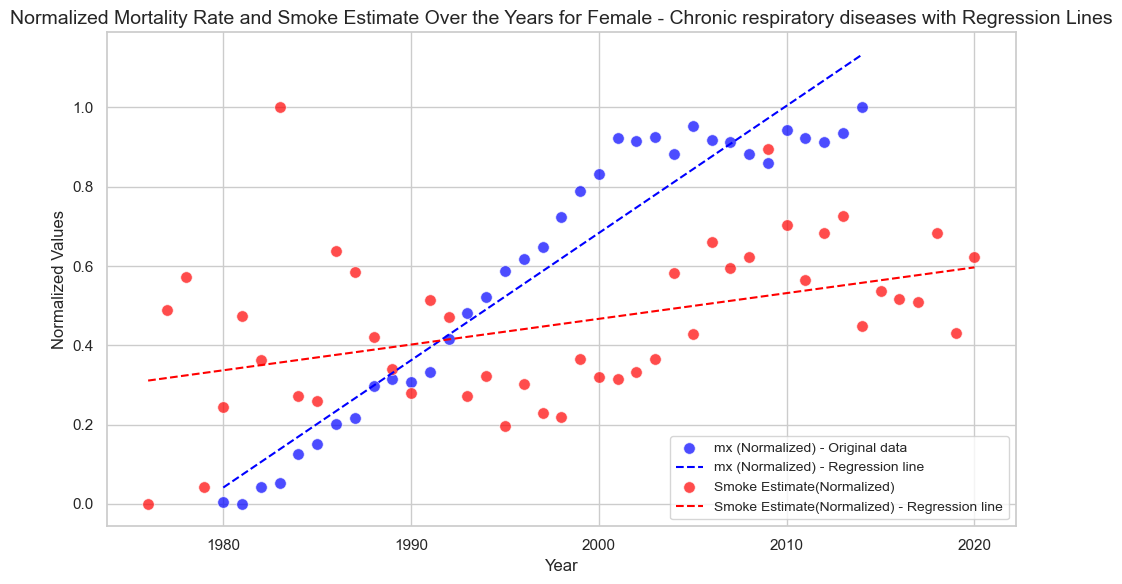

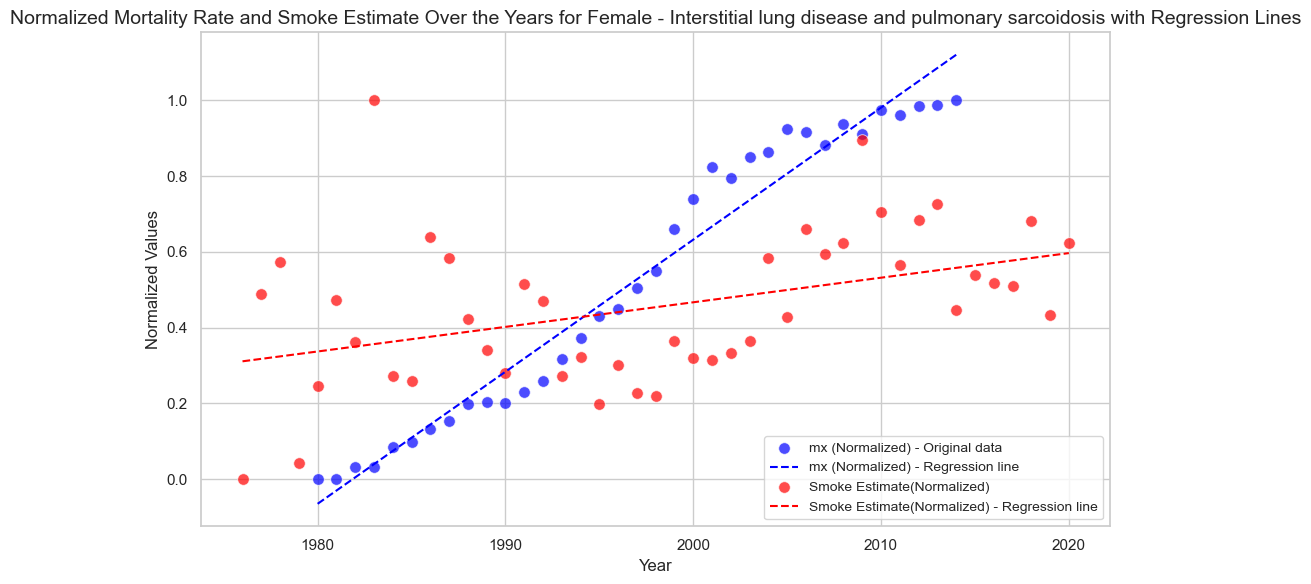

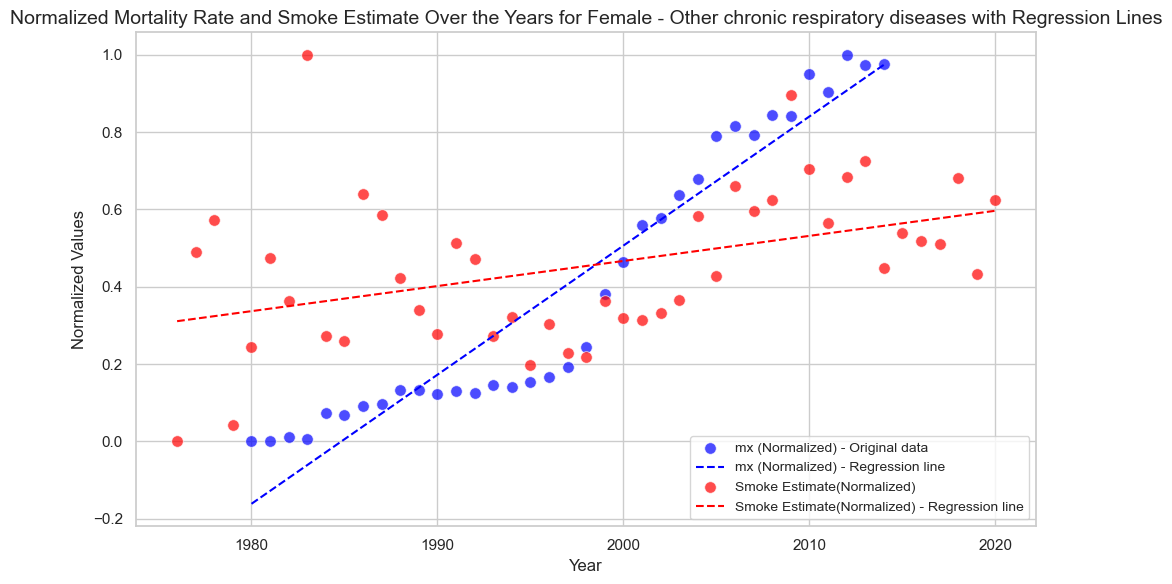

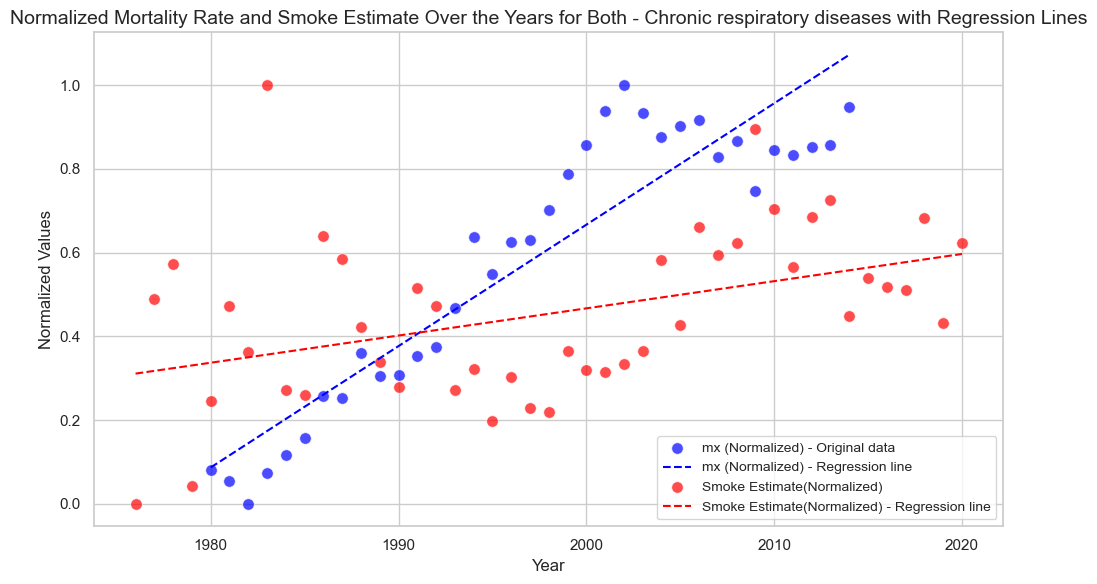

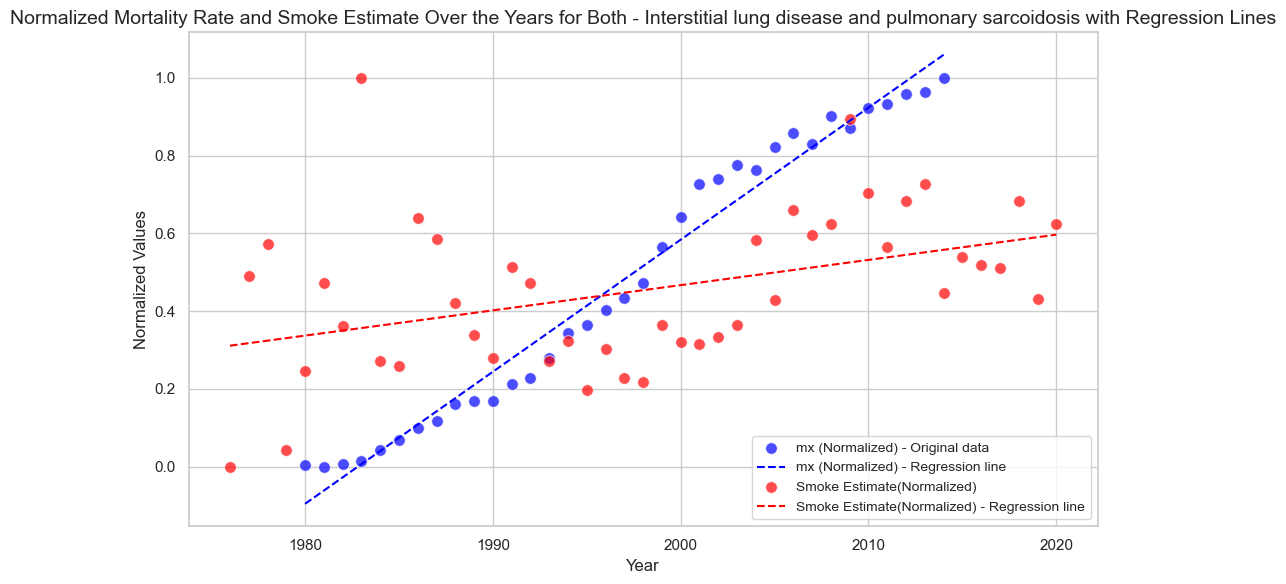

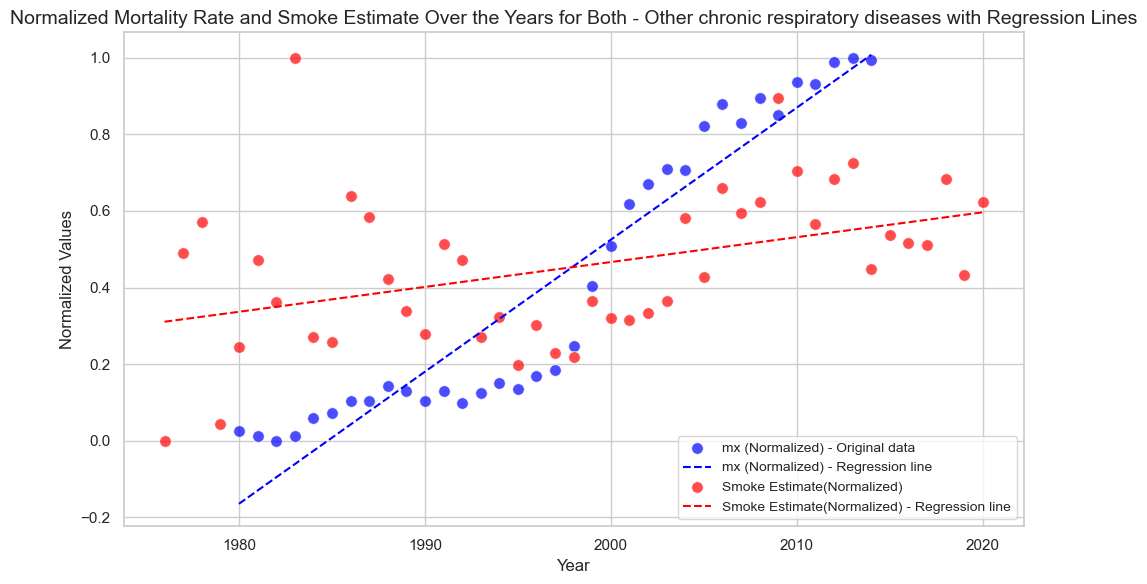

In [73]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

# Set seaborn style for better aesthetics
sns.set(style="whitegrid")

# Assuming health_data is your main dataset containing information about health data

# Array of unique 'sex' and 'cause_name' combinations
sex_values = ['Male', 'Female', 'Both']
cause_names = ['Chronic respiratory diseases',
               'Interstitial lung disease and pulmonary sarcoidosis',
               'Other chronic respiratory diseases']

# Iterate through all combinations of sex and cause_name
for sex in sex_values:
    for cause in cause_names:
        data = health_data[(health_data['sex'] == sex) & (health_data['cause_name'] == cause)]
        
        # Check if data exists for the combination
        if not data.empty:
            years = data['year_id'].values.reshape(-1, 1)
            mx_values = data['mx']
            
            # Perform linear regression
            regression = LinearRegression()
            regression.fit(years, mx_values)
            predicted_mx = regression.predict(years)
                  
            #We merge the data for the plotting
            merged_data1 = pd.merge(data[['mx', 'year_id']], average_smoke_area_distance_estimate_data[['Year', 'Max average_smoke_area_distance_estimate']], left_on='year_id', right_on='Year')

            # Calculate the correlation between 'mx' and 'Smoke Estimate' for the common years
            correlation1 = merged_data1['mx'].corr(merged_data1['Max average_smoke_area_distance_estimate'])
            #print(f"Correlation between 'mx' and 'Smoke Estimate' for => {sex} - {cause}: {correlation1}")
                       
            # Normalize 'mx' from 'data'
            scaler = MinMaxScaler()
            mx_normalized = scaler.fit_transform(data['mx'].values.reshape(-1, 1))
            years_mx = data['year_id'].values.reshape(-1, 1)  # Reshape to a 2D array for regression

            # Normalize 'Max average_smoke_area_distance_estimate' from 'average_smoke_area_distance_estimate_data'
            max_average_smoke_area_distance_estimate_normalized = scaler.fit_transform(average_smoke_area_distance_estimate_data['Max average_smoke_area_distance_estimate'].values.reshape(-1, 1))
            years_max_average_smoke_area_distance_estimate = average_smoke_area_distance_estimate_data['Year'].values.reshape(-1, 1)  # Reshape to a 2D array for regression
            
            # Perform linear regression for 'mx' after normalization for 'data'
            regression_mx = LinearRegression()
            regression_mx.fit(years_mx, mx_normalized)
            predicted_mx_normalized = regression_mx.predict(years_mx)

            # Plotting 'mx' for 'data' over the years with regression lines using seaborn
            plt.figure(figsize=(10, 6))  # Adjust the figure size

            # Scatter plot with regression line for 'mx' for 'data' with enhanced aesthetics
            sns.scatterplot(x=data['year_id'], y=mx_normalized.flatten(), label='mx (Normalized) - Original data', color='blue', s=70, alpha=0.7)
            sns.lineplot(x=data['year_id'], y=predicted_mx_normalized.flatten(), color='blue', linestyle='--', label='mx (Normalized) - Regression line')

            # Scatter plot with regression line for 'Max average_smoke_area_distance_estimate' for 'average_smoke_area_distance_estimate_data' with enhanced aesthetics
            sns.scatterplot(x=average_smoke_area_distance_estimate_data['Year'], y=max_average_smoke_area_distance_estimate_normalized.flatten(), label='Smoke Estimate(Normalized)', color='red', s=70, alpha=0.7)
            sns.lineplot(x=average_smoke_area_distance_estimate_data['Year'], y=predicted_max_average_smoke_area_distance_estimate_normalized.flatten(), color='red', linestyle='--', label='Smoke Estimate(Normalized) - Regression line')

            plt.xlabel('Year', fontsize=12)  # Increase label font size
            plt.ylabel('Normalized Values', fontsize=12)  # Increase label font size
            plt.title(f'Normalized Mortality Rate and Smoke Estimate Over the Years for {sex} - {cause} with Regression Lines', fontsize=14)  # Increase title font size
            plt.legend(fontsize=10)  # Increase legend font size
            plt.tight_layout()  # Improves subplot spacing
            plt.show()


We can observe that the correlation ranges around the 0.4 range, which shows a medium to high correlation for the deaths and the smoke estimate. This is a good starting point to then further look at what causes are more related to wildfire incidents, and if the deaths are increasing during the wildfire season